<a href="https://colab.research.google.com/github/Vesalon/xla-nmf/blob/main/notebooks/green_minimization_fides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fides

In [2]:
import logging
import os

from matplotlib import pyplot as plt
import numpy as np

from src.hnmf_optimizer import HNMFOptimizer
from src.clusts import result_analysis
from green_model import reconstruct_general, gen_init_params,  gen_bounds, clustering_preprocess


# set true variables

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#       set true variables for generated observations       #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

### parameters ###

# The amplitudes of the original sources

# 2 sources 
As = np.array([0.5, 0.7])
# # positions of the source
Xs = np.array([
    [-0.1, -0.2],
    [-0.9, -0.8]
])



# Advection velocity
u_scaler = 0.05
# U = tf_c(np.array([0.05, 0]))
# Dispersivity
D = np.array([0.005, 0.00125])


### fixed known values ###

# the initial time the sources begin the release
Ts = -10.

# positions of the detectors
Xd = np.array([
    [0, 0],
    [-0.5, -0.5],
    [0.5, 0.5],
    [0.5, -0.5]
])


# time values of data
t = np.linspace(0, 20, 80)

# noise to add to 
noise_level = 1e-4


# NMF run

In [4]:
# generate observations from target variables with small noise

noise_level = 1e-4
observations = reconstruct_general(As, Xs, Ts, Xd, t, np.array([u_scaler]), D)
noise = noise_level/2 - noise_level*np.random.rand(*observations.shape)
observations += noise


I0000 00:00:1697781576.308435   20934 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
green_opt = HNMFOptimizer(
    model_fn = reconstruct_general,
    param_generator = gen_init_params,
    bound_generator = gen_bounds,
    input_args = ('t',),
    param_args = ('A_s', 'X_s', 'U', 'D'),
    constants = {'T_s': Ts, 'X_d': Xd},
    min_k = 1,
    max_k = 4,
    nsim = 100
)

res = green_opt(t, observations, opt_case='tr_optimizer')
Forclusts = clustering_preprocess(res)

Forclusts = Forclusts.groupby('num_sources', group_keys=False).apply(lambda group: result_analysis(
    group['points'].sum(),
    group['normF'].mean(),
    observations.size,
    group['num_sources'].iloc[0]
))

SIMULATIONS FOR 1 SOURCES TOOK 16.3405122756958 SECONDS
SIMULATIONS FOR 2 SOURCES TOOK 29.3649640083313 SECONDS
SIMULATIONS FOR 3 SOURCES TOOK 48.659937620162964 SECONDS
SIMULATIONS FOR 4 SOURCES TOOK 37.12441039085388 SECONDS
Clustering  2
Clustering  3
Clustering  4


In [6]:
Forclusts

,num_source,aic_score,avg_sillhouette_score,min_sillhouette_score,reconstruction_loss,centers
0,1,-1003.236217,1.000000,1.000000,13.831627,"[0.5135092853607446, -0.35192853886437603, -0...."
0,2,-3408.413211,1.000000,1.000000,0.007480,"[[0.4999399362748039, 0.7000173328438288], [-0..."
0,3,inf,0.392189,-0.541138,0.007830,"[[0.37037135428434653, 0.6325777197242449, 0.2..."
0,4,inf,0.307878,-0.630899,0.867629,"[[0.6617531871683273, 0.290077188145631, 0.904..."


In [7]:
def plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all, output_dir):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Number of Sources')
    ax1.set_ylabel('Reconstruction Error [%]', color=color)  # we already handled the x-label with ax1
    ax1.plot(numsources, recs_all, color=color,marker = 'o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score', color=color)
    ax2.plot(numsources, avgsilsall, color=color,label='Avg_sil',marker = 'o')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot(numsources, minsillsall, color='pink', label='Min_sill', marker='o')
    ax2.legend(loc='upper right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(output_dir+"Selection_plot.png")
    plt.show()

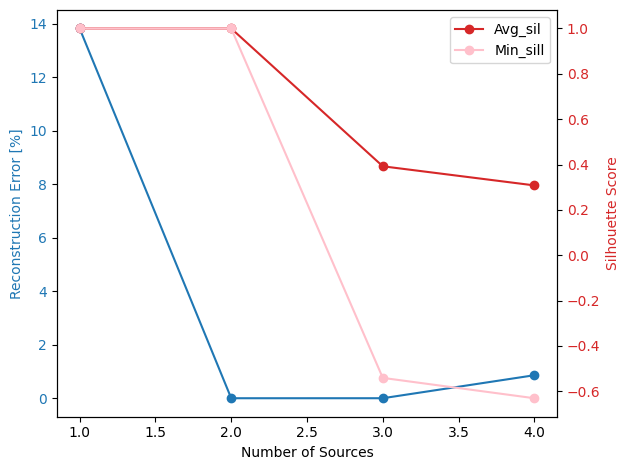

In [8]:
OUTPUTDIR = "Results/"
os.makedirs(OUTPUTDIR,exist_ok=True)

numsources = Forclusts['num_source'].values
avgsilsall    = Forclusts['avg_sillhouette_score'].values
minsillsall   = Forclusts['min_sillhouette_score'].values
recs_all   = Forclusts['reconstruction_loss'].values
plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all,OUTPUTDIR)

In [9]:
Forclusts['centers'].iloc[1]

array([[ 0.49993994,  0.70001733],
       [-0.10001384, -0.89997422],
       [-0.20000133, -0.80001192],
       [ 0.04999891,  0.04999891],
       [ 0.00500001,  0.00500001],
       [ 0.00125014,  0.00125014]])

In [10]:
ground_truth=np.vstack([As,Xs.T])
ground_truth

array([[ 0.5,  0.7],
       [-0.1, -0.9],
       [-0.2, -0.8]])